### AUDIO_DATA

El audio ha sido siempre una señal unidimensional.  Y se almacena por el hecho de que sampleamos y cuantizamos la entrada del audio.  El Sampling o muestreo, se refiere en la frecuencia con que cogemos un punto para que sea guardado en un archivo y la cuantización se refiere a la resolución de cada punto de audio en sí.  Y esto es representado por un número de bits.  Lo que conocemos como 8, 16, 32, etc. bits.

De cualquier manera, podemos separar el audio en datos para representarlo.  Así que como por ejemplo el tiempo es una dimensión independiente.  La frecuencia, otra. Y así podemos extraer diferentes features para realizarlo.

Existen varias formas de extraer *features* de las representaciones de audio para que nuestro algoritmo pueda funcionar.  Las 4 categorías que podemos obtener, visualmente sería asi:
1. Variables del tiempo (RMSE de la onda de sonido)
2. Variables de Frecuencia (Amplitud individual de las frecuencias)
3. Variables perceptuales (MFCC)
4. Variables por ventanas (Estableciendo distancias de ventanas a través de la onda de sonido)

Para realizar un aprendizaje supervisado, estoy utilizando un dataset que tiene 5435 samplers de paisajes sonoros. Todos los paisajes tienen una duración de 4 segundos. 

Existen 10 categorías (target) previamente fijadas que son las siguientes:
1. A/C - Air conditioner
2. Car Horn
3. Children Playing
4. Dog Bark
5. Drilling (taladro)
6. Engine Idling
7. Gun Shot
8. Jackhammer
9. Siren / Ambulance
10. Street Music

In [1]:
import IPython.display as ipd
import os
print(os.getcwd())

/Users/beba/Desktop/DATA SCIENCE/MACHINE LEARNING


In [2]:
ipd.Audio(filename='./AUDIO_DATA/Train/605.wav', rate=44100)

In [3]:
import librosa
from librosa import load

In [4]:
data_dir = "../input/AUDIO_DATA/Train/"

In [5]:
data, sampling_rate = librosa.load('./AUDIO_DATA/Train/605.wav')

In [6]:
data, sampling_rate

(array([0.        , 0.        , 0.        , ..., 0.00791149, 0.00060848,
        0.01468093], dtype=float32),
 22050)

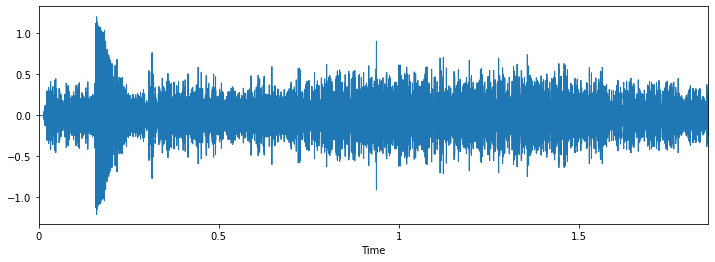

In [7]:

import matplotlib.pyplot as plt
import os
import librosa.display
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate);

In [8]:
train = pd.read_csv('./AUDIO_DATA/train.csv')

In [9]:
train.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


Class:  siren


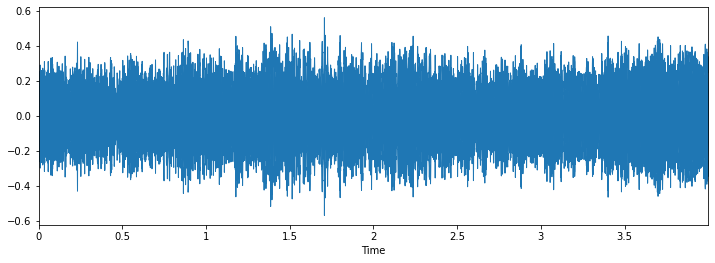

In [11]:
# para visualizar un archivo 'random' del dataset

import random

i = random.choice(train.index)

audio_name = train.ID[i]
path = os.path.join(data_dir, 'Train', str(audio_name) + '.wav')

print('Class: ', train.Class[i])
x, sr = librosa.load('./AUDIO_DATA/Train/' + str(train.ID[i]) + '.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr);

#### MFCC 
Para poder procesar el audio y extraer los *features* me basé en Mel-Frecuency Cepstrums.  Que es una representación de una distribución de potencia en frecuencia que componen un sonido.  En MFCC las bandas de frecuencia, están distibuidas en espacios iguales lo que se asemeja más al sistema auditivo humano.

Este proceso de audio se utiliza en los dispositivos de reconocimiento de voz.

Se basa en la Escala Mel (Mel Scale) que es una escala perceptual de timbres definidos como iguales en distancia entre uno y otro.  Así que finalmente, se basa en herzios y la escala mel.

In [12]:
audio_path = './AUDIO_DATA/Train/1606.wav'
example , sr_ex = librosa.load(audio_path)

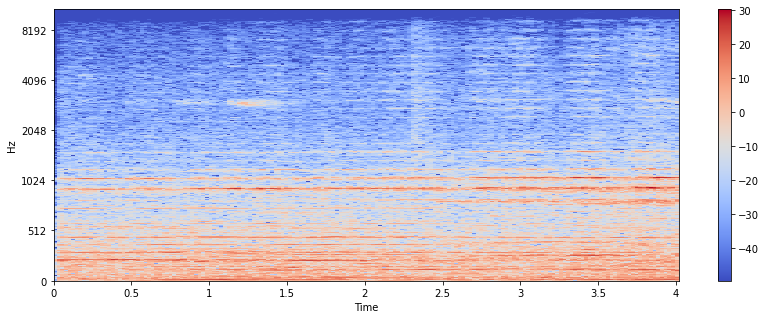

In [13]:
example = librosa.stft(example)
Xdb = librosa.amplitude_to_db(abs(example))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
from scipy.io import wavfile
from python_speech_features import mfcc

In [15]:
import soundfile as sf

**Función para meter los datos de audio a X y las clases a Y**

In [33]:
def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 

def get_audios():
    train_path = "./AUDIO_DATA/Train/"
    train_file_names = os.listdir(train_path)
    train_file_names.sort(key=lambda x: int(x.partition('.')[0]))
    
    samples = []
    for file_name in train_file_names:
        x, sr = sf.read(train_path + file_name, always_2d=True) # datos y sample rate
        x = parse_audio(x)
        samples.append(mean_mfccs(x))
        
    return np.array(samples)

def get_samples():
    df = pd.read_csv('./AUDIO_DATA/train.csv') # añadimos el target
    return get_audios(), df['Class'].values

In [34]:
X, Y = get_samples()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4348, 20), (1087, 20), (4348,), (1087,))

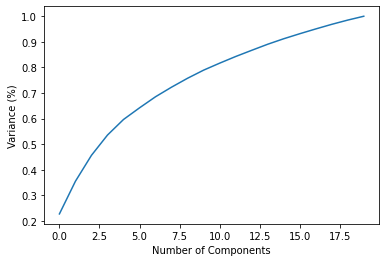

In [21]:
# estandarizamos y hacemos un plot para ver si nos ayuda a eliminar ruido

scaler = StandardScaler()
scaler.fit(X_train)
x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [22]:
# definimos los parámetros para encontrar el mejor modelo:

grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# creamos un GridSearch

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [23]:
print('Model Score:', model.score(x_test_scaled, y_test))

y_predict = model.predict(x_test_scaled)

Model Score: 0.9346826126954921


In [24]:
print('Matriz de confusión: \n', confusion_matrix(y_predict, y_test))

Matriz de confusión: 
 [[133   2   3   4   0   0   0   0   2   0]
 [  0  34   0   1   0   0   0   0   0   1]
 [  0   3  99  10   2   2   0   0   1   4]
 [  0   1   0  91   1   0   1   0   2   1]
 [  0   2   0   0 128   0   0   0   0   0]
 [  0   0   0   1   0 128   0   0   0   1]
 [  0   1   2   4   1   0  39   0   0   0]
 [  0   1   1   1   0   0   0 144   0   2]
 [  0   0   0   3   0   0   0   0 107   0]
 [  0   4   2   2   1   0   0   1   0 113]]



>
>
>
>
### UNSUPERVISED LEARNING


### t-SNE
**t-Distributed Stochastic Neighbor Embedding**

Con la técnica de t-SNE pasaremos nuestros datas de varias dimensiones a 2 dimensiones. ESta técnica se utiliza para la visualizción de datasets con muchas dimensiones.  Y con ello, para poder realizar un scatter plot.

In [27]:
# primero, etandarizamos los datos
scaler = StandardScaler()
x_std = scaler.fit_transform(X)

In [28]:
x_std

array([[ 8.87677470e-01,  1.14462653e+00, -9.33657619e-01, ...,
         6.19391478e-01,  2.58185261e-01,  9.16717756e-01],
       [ 1.32834175e+00,  9.28224478e-01, -8.88161268e-01, ...,
        -6.15427073e-01, -1.11106110e-03, -2.63437540e-01],
       [ 1.09958661e+00, -8.14750546e-01, -1.88164216e+00, ...,
        -2.78038263e+00,  1.58609746e+00, -1.94786454e+00],
       ...,
       [-1.01289944e-01, -1.97129374e+00,  3.93083365e-01, ...,
        -4.76656133e-01, -8.29265661e-01, -1.74624035e-01],
       [-4.33994351e-01,  6.59675313e-01, -1.16570751e-01, ...,
         5.81178391e-01,  1.00636483e+00, -6.98713774e-01],
       [-5.72082361e-01,  1.55665834e+00,  2.26169741e+00, ...,
         7.84885327e-02,  1.04566367e+00,  1.57992962e+00]])

In [26]:
# En el No Supervisado, no tenemos un target definido.  Lo definiremos en el KMeans.
import numpy as np
from matplotlib import pyplot as plt
from tsne import bh_sne

# convertimos el audio data a una matriz de float64. float64 se necesita para bh_sne
x_data = np.asarray(x_std).astype('float64')

# y aquí guardamos los nuevos datos de 2 dimensiones en una variable para visualización.
vis_data = bh_sne(x_data)

In [85]:
vis_data

array([[ 10.86676981,  31.71713067],
       [-21.34124692,  25.19805369],
       [-17.44629691,   9.56619521],
       ...,
       [  9.42665406, -29.71868364],
       [-12.78252684, -20.93294014],
       [ 42.18575599,  13.66098662]])

In [29]:
# nos creamos el modelo de KMeans

from sklearn.cluster import KMeans
k = 10
kmeans = KMeans(n_clusters=k, random_state=101) # creamos algoritmo k means con número de clusters.
y_pred = kmeans.fit_predict(vis_data) # predecimos para las X que tenemos, cuál es el cluster en el que cae.

mapping = np.array([0,1,2,3,4,5,6,7,8,9]) # hago esto para que me ordene los clusters.
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

In [31]:
# defino los colores y tamaño que tendrá el scatterplot por defecto:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

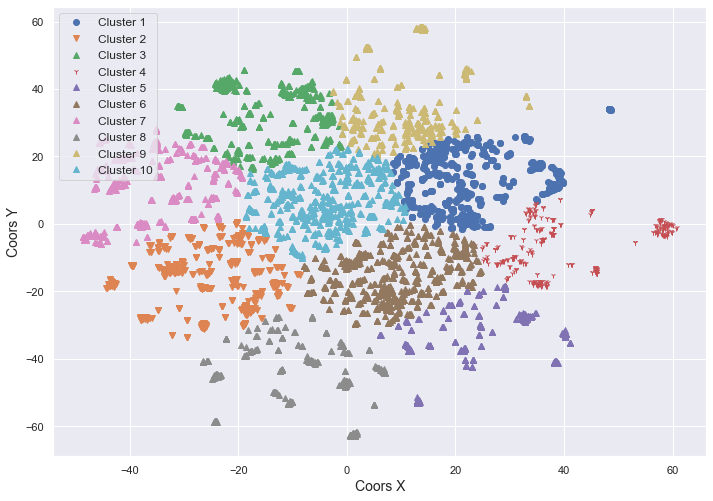

In [32]:
plt.plot(vis_data[y_pred==0, 0], vis_data[y_pred==0, 1], "o", label="Cluster 1")
plt.plot(vis_data[y_pred==1, 0], vis_data[y_pred==1, 1], "v", label="Cluster 2")
plt.plot(vis_data[y_pred==2, 0], vis_data[y_pred==2, 1], "^", label="Cluster 3")
plt.plot(vis_data[y_pred==3, 0], vis_data[y_pred==3, 1], "1", label="Cluster 4")
plt.plot(vis_data[y_pred==4, 0], vis_data[y_pred==4, 1], "2", marker='^', label="Cluster 5")
plt.plot(vis_data[y_pred==5, 0], vis_data[y_pred==5, 1], "3", marker='^', label="Cluster 6")
plt.plot(vis_data[y_pred==6, 0], vis_data[y_pred==6, 1], "4", marker='^', label="Cluster 7")
plt.plot(vis_data[y_pred==7, 0], vis_data[y_pred==7, 1], "8", marker='^', label="Cluster 8")
plt.plot(vis_data[y_pred==8, 0], vis_data[y_pred==8, 1], "s", marker='^', label="Cluster 9")
plt.plot(vis_data[y_pred==9, 0], vis_data[y_pred==9, 1], "p", marker='^', label="Cluster 10")
plt.xlabel("Coors X", fontsize=14)
plt.ylabel("Coors Y", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()